## Wave Equation using Finite Differences and the Method of Lines

Authors: Oscar Reula, Joaquin Pelle, Pablo Montes


##### [Click here to download this notebook](/weave/lab03/waveequation.ipynb)

We will use the `DifferentialEquations.jl` package.  
This notebook contains modifications of examples from the following two pages:


[https://tutorials.sciml.ai/html/introduction/03-optimizing_diffeq_code.html](https://tutorials.sciml.ai/html/introduction/03-optimizing_diffeq_code.html)

[http://juliamatrices.github.io/BandedMatrices.jl/latest/#Creating-banded-matrices-1](http://juliamatrices.github.io/BandedMatrices.jl/latest/#Creating-banded-matrices-1)

## Method of Lines  
We will solve hyperbolic equations using the *method of lines* and *finite difference* approximations. This means that starting from a scalar system of the form

$$
u_t = u_x
$$

we will initially approximate it using a finite difference operator $D_x$ in the spatial direction, yielding

$$
v_t = D_x\; v.
$$

Here, $v$ is a version of $u$ discretized *only* in space. That is, if we take a grid of $N$ points, $v$ will be a vector of $N$ elements that depends continuously on time.

At this stage, we effectively have a system of $N$ ordinary differential equations, which we can approximate using a suitable ODE integrator. In this way, we arrive at a discretization in both space and time.


## Wave Equation

We will solve the wave equation  

$$
\phi_{tt} = \phi_{xx}
$$

To express it in standard form, we define two new variables, $u := \phi_x$ and $v := \phi_t$. This system then becomes

$$
\begin{array}{rl}
\phi_t & = & v \\
v_t & = & u_x \\
u_t & = & v_x,
\end{array}
$$

where we have used that $u_t := \phi_{xt} = \phi_{tx} := v_x$, and $v_t := \phi_{tt} = \phi_{xx} = u_x$.  

Since the equation for $\phi$ can be integrated once $(u, v)$ are known, and $\phi$ is not necessary to solve the rest of the system, we will ignore it for now.

### Diagonalization of the system

If we define the variables $u^{+} = u+v$ and $u^{-} = u-v$ we can obtain a diagonalized system,

$$
\begin{array}{rl}
u^+_t & = & u^+_x \\
u^-_t & = & -u^-_x,
\end{array}
$$

where the solution consists of two independent waves, $u^{+}$ to the left and $u^{-}$ to the right:

$$
\begin{array}{rl}
u^{+}(x,t) = u^{+}_0(x+t)\\
u^{-}(x,t) = u^{-}_0(x-t)
\end{array}
$$

Therefore, the solutions of the original system will be linear combinations of these two solutions, which depend on the initial data.


For example, if we take as initial data $\phi_0(x) = e^{-x^{2}}$ and $\phi_t(x, t=0) = 0$ with periodic boundary conditions on the interval $(-4, 4)$, the exact solution will be

┌ Info: Saved animation to /Users/reula/Docencia/PDE/book/weave/lab03/wave_example.gif
└ @ Plots /Users/reula/.julia/packages/Plots/Ec1L1/src/animation.jl:156


Plots.AnimatedGif("/Users/reula/Docencia/PDE/book/weave/lab03/wave_example.gif")
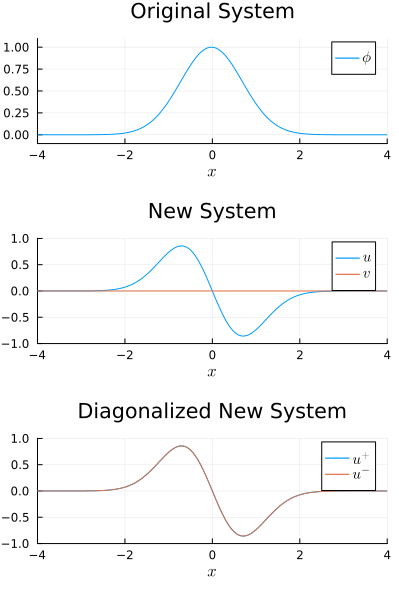

In [ ]:
using Plots

N = 201
dx = 8.0/(N-1)
x = range(-4.0, 4.0, length = N) # spatial values
times = range(0, 8, length = 200) # temporal values

function return_to_interval(xini::Number, xfin::Number, x)
    # This function takes a value x and returns it to the interval [xini, xfin)
    length = xfin - xini
    offset = x + xini
    factor = offset / length
    x = xini + (factor - floor(factor)) * length
end

function up_0(x)
    #(u^+)_0
    x = return_to_interval(-4, 4, x)
    return -2 * x * exp(-x^2)
end

function um_0(x)
    #(u^-)_0
    x = return_to_interval(-4, 4, x)
    return -2 * x * exp(-x^2)
end

anim = @animate for t in times
    up = up_0.(x .+ t)
    um = um_0.(x .- t)
    u = 0.5 * (up + um)
    v = 0.5 * (up - um)
    ϕ = [dx * sum(u[1:i]) for i in 1:N]
    ϕ = ϕ .- minimum(ϕ)

    lfs = 10
    p1 = plot(x, ϕ, label = "\$ \\phi \$", ylim = (-0.1, 1.1), xlim = (-4, 4),
              xlabel = "\$x\$", legendfontsize = lfs)
    title!(p1, "Original System")

    p2 = plot(x, u, label = "\$u\$", legendfontsize = lfs)
    plot!(p2, x, v, label = "\$v\$", ylim = (-1, 1), xlim = (-4, 4),
          xlabel = "\$x\$", legendfontsize = lfs)
    title!(p2, "New System")

    p3 = plot(x, up, label = "\$u^{+}\$", legendfontsize = lfs)
    plot!(p3, x, um, label = "\$u^{-}\$", ylim = (-1, 1), xlim = (-4, 4),
          xlabel = "\$x\$", legendfontsize = lfs)
    title!(p3, "Diagonalized New System")

    plot(p1, p2, p3, layout = (3, 1), size = (400, 600))
end

gif(anim, "wave_example.gif", fps = 30)


Estamos usando Julia, por lo que cargaremos algunos paquetes para manejar matrices, resolver ODEs y graficar.

In [1]:
using OrdinaryDiffEq  
using Plots
using LinearAlgebra
using BandedMatrices
using SparseArrays

Now we add some parameters for the simulation. Some values are arbitrary, and you may try playing with them.  
$N$ is the number of points in the spatial discretization.  
We will solve the *periodic* problem, so if the grid starts at $1$ and ends at $N$, we identify the points $(N+1, N+2, \ldots)$ with $(1, 2, \ldots)$, and the points $(0, -1, \ldots)$ with $(N, N-1, \ldots)$.


In [ ]:
N = 500            # Number of points in the spatial discretization
L = 1.0            # Spatial interval
dx = L/N           # dx
T = 10.0           # Final time
dt = 1.0 * dx      # We take dt ≈ dx/speed_max to satisfy the CFL condition and
                   # ensure stability of the algorithm


r0 = zeros(N, 2)   # Discretization of the fields u and v
x = [dx * i for i in 0:N-1];   # x coordinates, needed to define the initial data

In [104]:
dt 

0.005

We now define the finite difference schemes. They are implemented as matrices that multiply the solution vectors.  
The matrices are defined as sparse for greater computational efficiency.  
In general, defining numerical derivatives using matrices is not efficient, but the cases we will work with are simple enough to be illustrative.

In [105]:
function create_D_2_per(N)
    D_2_per = sparse(Tridiagonal([-0.5 for i in 1:N-1],[0.0 for i in 1:N],[0.5 for i in 1:N-1]))
    D_2_per[1,end] = -0.5
    D_2_per[end,1] = 0.5
    dropzeros!(D_2_per)
    return D_2_per
end


function create_D2_2_per(N)
    D2_2_per = BandedMatrix{Float64}(Zeros(N,N), (N-1,N-1))
    D2_2_per[band(0)] .= -2.0
    D2_2_per[band(1)] .= 1.0
    D2_2_per[band(-1)] .= 1.0
    
    D2_2_per[band(N-1)] .= 1.0
    D2_2_per[band(-N+1)] .= 1.0
    
    D2_2_per = sparse(D2_2_per)
    dropzeros!(D2_2_per)
    return D2_2_per
end

function create_D_4_per(N)
    D_4_per = BandedMatrix{Float64}(Zeros(N,N), (N-1,N-1))
    D_4_per[band(0)] .= 0.0
    D_4_per[band(1)] .= 2.0/3.0
    D_4_per[band(-1)] .= -2.0/3.0
    D_4_per[band(2)] .= -1.0/12.0
    D_4_per[band(-2)] .= 1.0/12.0
    
    D_4_per[band(N-1)] .= -2.0/3.0
    D_4_per[band(N-2)] .= 1.0/12.0
    
    D_4_per[band(-N+1)] .= 2.0/3.0
    D_4_per[band(-N+2)] .= -1.0/12.0
    
    D_4_per = sparse(D_4_per)
    dropzeros!(D_4_per)
    return D_4_per
end;

In [107]:
println("Second-order periodic approximation of the first derivative:")
println(create_D_2_per(8))
println()
println("Fourth-order periodic approximation of the first derivative:")
println(round.(create_D_4_per(8), digits = 4))

Second-order periodic approximation of the first derivative:
sparse([2, 8, 1, 3, 2, 4, 3, 5, 4, 6, 5, 7, 6, 8, 1, 7], [1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8], [-0.5, 0.5, 0.5, -0.5, 0.5, -0.5, 0.5, -0.5, 0.5, -0.5, 0.5, -0.5, 0.5, -0.5, -0.5, 0.5], 8, 8)

Fourth-order periodic approximation of the first derivative:
sparse([2, 3, 7, 8, 1, 3, 4, 8, 1, 2, 4, 5, 2, 3, 5, 6, 3, 4, 6, 7, 4, 5, 7, 8, 1, 5, 6, 8, 1, 2, 6, 7], [1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 6, 6, 6, 6, 7, 7, 7, 7, 8, 8, 8, 8], [-0.6667, 0.0833, -0.0833, 0.6667, 0.6667, -0.6667, 0.0833, -0.0833, -0.0833, 0.6667, -0.6667, 0.0833, -0.0833, 0.6667, -0.6667, 0.0833, -0.0833, 0.6667, -0.6667, 0.0833, -0.0833, 0.6667, -0.6667, 0.0833, 0.0833, -0.0833, 0.6667, -0.6667, -0.6667, 0.0833, -0.0833, 0.6667], 8, 8)


We now define the right-hand side of the equations in the method of lines, that is, the spatial discretization.

In [108]:
function F!(dr, r, p, t)
    # second order version
    dx, D = p
    h = 1.0 / dx
    u = @view r[:,1]
    v = @view r[:,2]
    du = @view dr[:,1]
    dv = @view dr[:,2]
    mul!(du, D, v, h, 0)  # du/dt = h * D * v
    mul!(dv, D, u, h, 0)  # dv/dt = h * D * u
    # Note: mul!(C, A, B, α, β) performs the operation α*A*B + β*C and stores it in C
end;

We now specify the initial data. In this particular case, we choose one for which $u^{+}$ vanishes.  Therefore, the only wave we should observe is $u^{-}$ propagating to the right.  You may experiment by changing the initial data to something else.

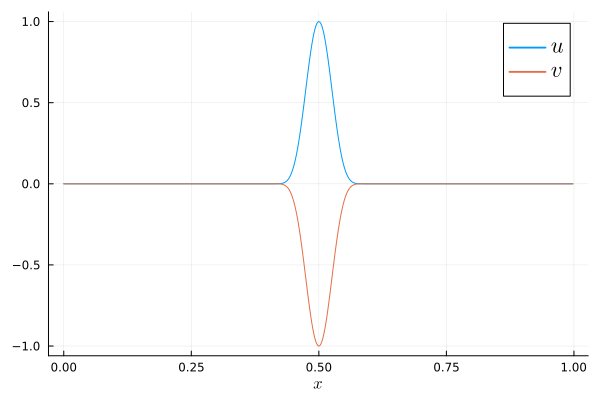

In [109]:
x0 = 0.4; x1 = 0.6
function create_r0!(r0,x0,x1,N,p)
    u = @view r0[:,1]
    v = @view r0[:,2]

    for i in 1:N
        x[i] = dx*(i-1)
        if x[i] > x0 && x[i] < x1
            u[i] = (x[i] - x0)^p * (x[i] - x1)^p / (x1-x0)^(2p) * 2^(2p)
            v[i] = -u[i]
        end
    end
end

create_r0!(r0,x0,x1,N,8)
plot(x, r0, label = ["\$u\$" "\$v\$"], xlabel = "\$x\$", legendfontsize = 15)

We define two problems with different precision

In [110]:
D_2_per = create_D_2_per(N)
D_4_per = create_D_4_per(N)

p2 = (dx, D_2_per)
p4 = (dx, D_4_per)
@time prob2 = ODEProblem(F!,r0,(0.0,T),p2);
@time prob4 = ODEProblem(F!,r0,(0.0,T),p4);

  0.000075 seconds (64 allocations: 2.438 KiB)
  0.000072 seconds (64 allocations: 2.438 KiB)


Now we solve

In [111]:
@time sol2 = solve(prob2,RK4(),dt=dt, adaptive = false);

  0.059343 seconds (122.34 k allocations: 51.707 MiB, 6.72% gc time, 28.82% compilation time: 100% of which was recompilation)


In [112]:
@time sol4 = solve(prob4,RK4(),dt=dt, adaptive = false);

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /Users/reula/.julia/packages/SciMLBase/0ZQSg/src/integrator_interface.jl:631


  0.034771 seconds (11.40 k allocations: 14.168 MiB, 49.40% gc time)


Finally, we plot the solution at different times. Note that since the propagation speed is $1$ and the system is periodic with spatial length $1$,  we expect to recover the initial data at times $t = i \cdot 1.0$.

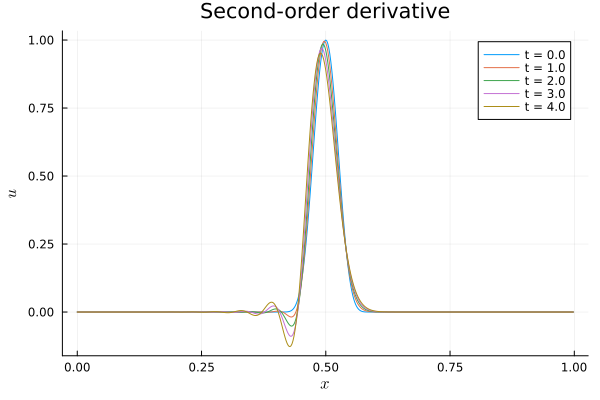

In [113]:
plt = plot()
for i in 0:4
    plot!(plt,x, sol2(T*0.1*i)[:,1], label = "t = $(T*0.1*i)")
end
title!("Second-order derivative")
xlabel!("\$x\$")
ylabel!("\$u\$")
display(plt)

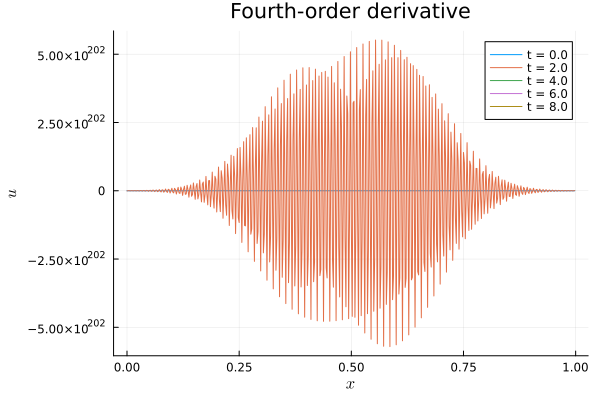

In [114]:
plt = plot()
for i in 0:4
    plot!(plt,x, sol4(T*0.2*i)[:,1], label = "t = $(T*0.2*i)")
end
title!("Fourth-order derivative")
xlabel!("\$x\$")
ylabel!("\$u\$")
display(plt)

┌ Info: Saved animation to /Users/reula/Docencia/PDE/book/weave/lab03/wave_anim_fps10.gif
└ @ Plots /Users/reula/.julia/packages/Plots/Ec1L1/src/animation.jl:156


Plots.AnimatedGif("/Users/reula/Docencia/PDE/book/weave/lab03/wave_anim_fps10.gif")
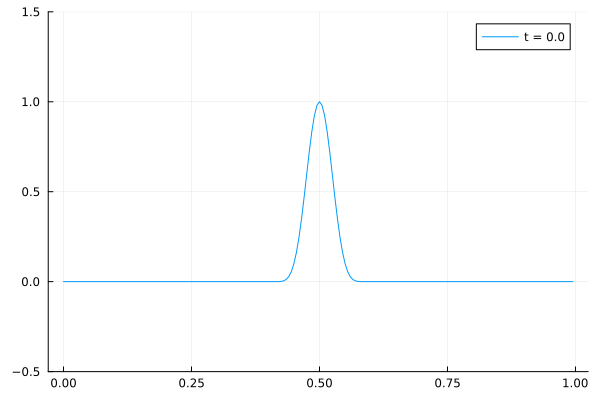

In [13]:
anim = @animate for i in 0:100
    plot(x, sol2(i*T/100)[:,1], ylim = (-0.5, 1.5), label = "t = $(i*T/100)")
end

gif(anim, "wave_anim_fps10.gif", fps = 10)
    

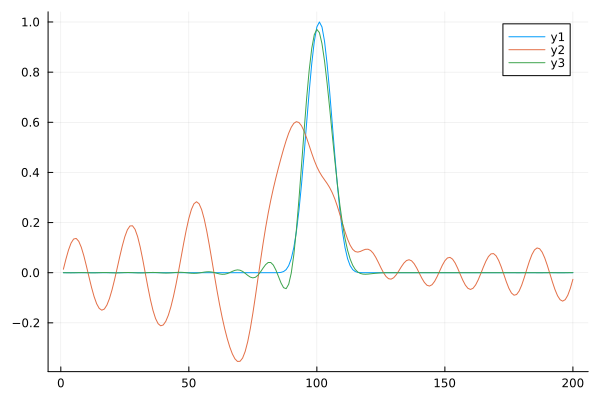

In [14]:
plot([r0[:,1],sol2(T)[:,1],sol4(T)[:,1]])
#plot(x,sol.u)

In [15]:
function Q(sol1, sol2, sol4, t, i)
    return norm(sol1(t)[1:end,i] - sol2(t)[1:2:end,i])/norm(sol2(t)[1:2:end,i] - sol4(t)[1:4:end,i])
end;

In [16]:
p = 8
N = 160            # Number of points in the spatial discretization
L = 1.0            # Spatial interval
dx = L/N           # dx
T = 1.0            # Final time

# We take dt ≈ dx/speed_max to satisfy the CFL condition and
# ensure the stability of the algorithm.
# dt = 1.0 * dx
dt = 1e-6

r0 = zeros(N, 2)   # Discretization of the fields u and v
x = [dx * i for i in 0:N-1]   # x coordinates, needed to define the initial data

D_4_per = create_D_4_per(N)
p4 = (dx, D_4_per)

create_r0!(r0, x0, x1, N, p)

prob4 = ODEProblem(F!, r0, (0.0, T), p4)
sol1 = solve(prob4, RK4(), dt = dt, saveat = 0.001, adaptive = false);

In [17]:
N = 2 * N          # Number of points in the spatial discretization
dx = L / N         # dx

# dt = 1.0 * dx     # We take dt ≈ dx/speed_max to satisfy the CFL condition and
                   # ensure the stability of the algorithm.
dt = 1e-6

r0 = zeros(N, 2)   # Discretization of the fields u and v
x = [dx * i for i in 0:N-1]   # x coordinates, needed to define the initial data

D_4_per = create_D_4_per(N)
p4 = (dx, D_4_per)

create_r0!(r0, x0, x1, N, p)

prob4 = ODEProblem(F!, r0, (0.0, T), p4)
sol2 = solve(prob4, RK4(), dt = dt, saveat = 0.001, adaptive = false);

In [18]:
N = 2 * N          # Number of points in the spatial discretization
L = 1.0            # Spatial interval
dx = L / N         # dx
T = 1.0            # Final time

# dt = 1.0 * dx     # We take dt ≈ dx/speed_max to satisfy the CFL condition and
                   # ensure the stability of the algorithm.
dt = 1e-6

r0 = zeros(N, 2)   # Discretization of the fields u and v
x = [dx * i for i in 0:N-1]   # x coordinates, needed to define the initial data

D_4_per = create_D_4_per(N)
p4 = (dx, D_4_per)

create_r0!(r0, x0, x1, N, p)

prob4 = ODEProblem(F!, r0, (0.0, T), p4)
sol4 = solve(prob4, RK4(), dt = dt, saveat = 0.001, adaptive = false);

In [19]:
Q(sol1,sol2,sol4,dt,1)

15.564542843879963

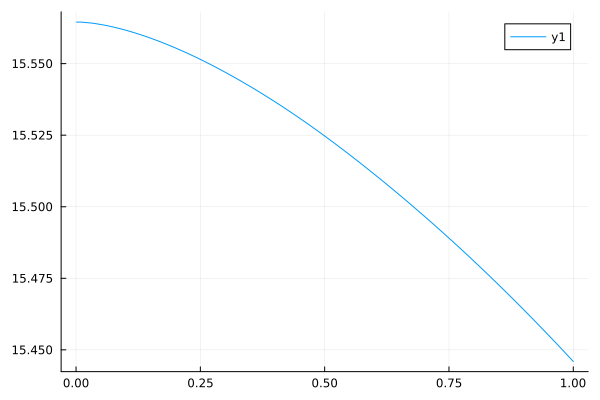

In [20]:
plot(sol1.t,map(x -> Q(sol1,sol2,sol4,x,1), sol1.t))

In [21]:
function create_r0_noise!(r0,x0,x1,N,p)
    u = @view r0[:,1]
    v = @view r0[:,2]

    for i in 1:N
        x[i] = dx*(i-1)
        if x[i] > x0 && x[i] < x1
            u[i] = (x[i] - x0)^p * (x[i] - x1)^p / (x1-x0)^(2p) * 2^(2p) * (-1)^i
            v[i] = -u[i]
        end
    end
end;

In [22]:
p = 8
N = 160            # Number of points in the spatial discretization
L = 1.0            # Spatial interval
T = 1.0            # Final time

# We take dt ≈ dx/speed_max to satisfy the CFL condition and
# ensure the stability of the algorithm.
dx = L / N 
dt = 1.0 * dx 
# dt = 1e-6

r0_noise = zeros(N, 2)    # Discretization of the fields u and v (noisy initial data)
r0_smooth = zeros(N, 2)   # Discretization of the fields u and v (smooth initial data)

x = [dx * i for i in 0:N-1]   # x coordinates, needed to define the initial data

D_4_per = create_D_4_per(N)
p4 = (dx, D_4_per)

create_r0_noise!(r0_noise, x0, x1, N, p)
create_r0!(r0_smooth, x0, x1, N, p)

prob4 = ODEProblem(F!, r0_noise, (0.0, T), p4)
sol_noise = solve(prob4, RK4(), dt = dt, adaptive = false)

prob4 = ODEProblem(F!, r0_smooth, (0.0, T), p4)
sol_smooth = solve(prob4, RK4(), dt = dt, adaptive = false);

┌ Info: Saved animation to /Users/reula/Docencia/PDE/book/weave/lab03/noise_anim_fps10.gif
└ @ Plots /Users/reula/.julia/packages/Plots/Ec1L1/src/animation.jl:156


Plots.AnimatedGif("/Users/reula/Docencia/PDE/book/weave/lab03/noise_anim_fps10.gif")
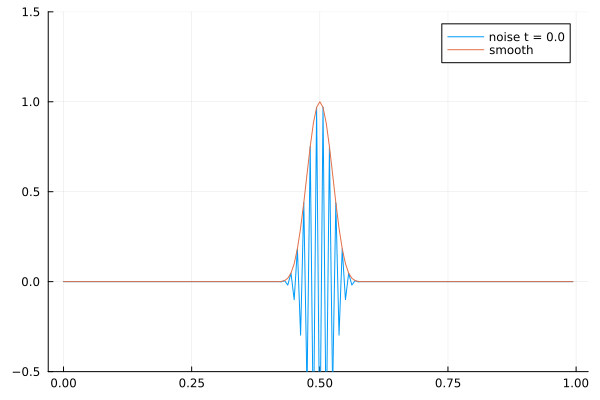

In [23]:
anim = @animate for i in 0:100
    plot(x, sol_noise(i*T/100)[:,1], ylim = (-0.5, 1.5), label = "noise t = $(i*T/100)")
    plot!(x, sol_smooth(i*T/100)[:,1], ylim = (-0.5, 1.5), label = "smooth")
end

gif(anim, "noise_anim_fps10.gif", fps = 10)